In [1]:
import pandas as pd
import json
import ast
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
releases = pd.read_csv('../Data_input/releases.csv')
tender = pd.read_csv('../Data_input/tender.csv')
awards = pd.read_csv('../Data_input/awards.csv')
parties = pd.read_csv('../Data_input/parties.csv')
montos = pd.read_csv('../Data_input/Montos.csv')
items = pd.read_csv('../Data_input/tender_items.csv')

## Preprocesado Tender

In [3]:
tender['tp_endDate'] = pd.to_datetime(tender['tp_endDate']).dt.date
tender['tp_endDate'] = pd.to_datetime(tender['tp_endDate'])

In [4]:
tender['tp_endDate'] = pd.to_datetime(tender['tp_endDate'])

## Preprocesado Awards

In [5]:
awards['date'] = pd.to_datetime(awards['date']).dt.date
awards['date'] = pd.to_datetime(awards['date'])

## Preprocesado Releases

In [6]:
releases['contracts_dateSigned'] = pd.to_datetime(releases['contracts_dateSigned']).dt.date
releases['contracts_dateSigned'] = pd.to_datetime(releases['contracts_dateSigned'])

## Red Flags

In [7]:
def NF003(df): #tender
    limited=df.loc[(df["procurementMethod"]=="limited")&(df["tp_durationInDays"]<10)]["ocid"].tolist()
    direct=df.loc[(df["procurementMethod"]=="direct")&(df["tp_durationInDays"]<9)]["ocid"].tolist() 
    selective = df.loc[(df["procurementMethod"]=="selective")&(df["tp_durationInDays"]<15)]["ocid"].tolist()
    mopen=df.loc[(df["procurementMethod"]=="open")&(df["tp_durationInDays"]<15)]["ocid"].tolist()
    redflag_NF003={"open":mopen,"selective":selective,"limited":limited,"direct":direct}
    df_NF003=pd.DataFrame.from_dict(redflag_NF003,orient="index").transpose().stack().reset_index()
    df_NF003.columns=["Nivel","procurementMethod","ocid"]
    df_NF003=df_NF003.drop(columns="Nivel")
    return df_NF003

In [8]:
def NF010(df,df_montos): #tender, montos
    df_montos_bienes=df_montos.loc[df_montos["Tipo"]=="Bienes"]#Separar los umbrales a utilizar
    df_montos_obras=df_montos.loc[df_montos["Tipo"]=="Obras"]
    #bienes
    df_value_bienes_norm = df.loc[df["mainProcurementCategory"].isnull()]
    df_value_bienes=df.loc[(df["mainProcurementCategory"]=="goods")]
    df_value_bienes=df_value_bienes.merge(df_montos_bienes,on ="procurementMethodDetails",how ="left")
    #Se verifica que el valor de amount se encuentre dentro de los límites, para este redflag se requiere
    #saber, si los valores se encuentran justo por debajo del límite, es decir +-10% del valor establecido
    bienes=df_value_bienes.loc[(df_value_bienes["value_amount"]>=(df_value_bienes["menor"]*0.9))|(df_value_bienes["value_amount"]<(df_value_bienes["mayor"]*0.9))]["ocid"].tolist()
    #Servicios
    df_value_servicios=df.loc[(df["mainProcurementCategory"]=="services")]
    servicios=df_value_servicios.loc[(df_value_servicios["value_amount"]>=(561000*0.9))|(df_value_servicios["value_amount"]<(182000*0.9))]["ocid"].tolist()
    #Obras
    df_value_obras =df.loc[(df["mainProcurementCategory"]=="works")]
    df_value_obras=df_value_obras.merge(df_montos_obras,on = "procurementMethodDetails",how = "left")
    obras=df_value_obras.loc[(df_value_obras["value_amount"]>=(df_value_obras["menor"]*0.9))|(df_value_obras["value_amount"]<(df_value_obras["mayor"]*0.9))]["ocid"].tolist()
    #Juntar los Ocid
    redflag_NF010={"bienes":bienes,"obras":obras,"servicios":servicios}
    df_NF010=pd.DataFrame.from_dict(redflag_NF010,orient="index").transpose().stack().reset_index()
    df_NF010.columns=["Nivel","mainProcurementCategory","ocid"]
    df_NF010=df_NF010.drop(columns="Nivel")
    return df_NF010

In [9]:
def NF011():
    df_items=items.merge(tender[["ocid","tp_startDate","procuringEntity_id","procurementMethod","procurementMethodDetails"]],on="ocid",how ="left")
    df_items["tp_startDate"]=pd.to_datetime(df_items["tp_startDate"])
    #Se realiza una agrupación por método, entidad contratante y tipo de compra, sacando un total del valor adjunto a cada grupo
    dfg_items=df_items.groupby(["procuringEntity_id","classification_id","procurementMethod","procurementMethodDetails",pd.Grouper(key="tp_startDate",freq="3M")])["unit_value_amount"].sum().reset_index()
    #Se separa cada una de las distintas secciones a comparar con los datos externos
    dfg_competitive = dfg_items.loc[(dfg_items["procurementMethod"]!="direct")]
    dfg_non_competitve = dfg_items.loc[(dfg_items["procurementMethod"]=="direct")]
    threshold = montos.loc[(montos["Tipo"]!="Obras")]
    dfg_competitive=dfg_competitive.merge(threshold[["procurementMethodDetails","mayor","menor"]], on="procurementMethodDetails", how="left")
    dfg_non_competitve=dfg_non_competitve.merge(threshold[["procurementMethodDetails","mayor","menor"]], on="procurementMethodDetails", how="left")
    entity_competitive = dfg_competitive.loc[(dfg_competitive["unit_value_amount"]>=(dfg_competitive["menor"]))|(dfg_competitive["unit_value_amount"]<(dfg_competitive["mayor"]))]["procuringEntity_id"].tolist()
    entity_non_competitive = dfg_non_competitve.loc[(dfg_non_competitve["unit_value_amount"]>=(dfg_non_competitve["menor"]))|(dfg_non_competitve["unit_value_amount"]<(dfg_non_competitve["mayor"]))]["procuringEntity_id"].tolist()
    redflag_NF011={"Competitive":entity_competitive,"Non_competitive":entity_non_competitive}
    df_NF011=pd.DataFrame.from_dict(redflag_NF011,orient="index").transpose().stack().reset_index()
    df_NF011.columns=["Nivel","procurementMethod","procuringEntity_id"]
    df_NF011=df_NF011.drop(columns="Nivel")
    return df_NF011

In [10]:
def NF025():
    # Solo participación de tenderers
    tenderers_id = pd.DataFrame(parties[parties['roles'] != 'buyer'].groupby('id')['roles'].value_counts())
    tenderers_id.rename(columns={'roles':'participations'}, inplace=True)
    tenderers_id.reset_index(inplace=True)
    tenderers_id = tenderers_id[tenderers_id['roles'] == 'tenderer']
    
    # Ganadores de cada ocid
    winners = awards['supplier_id'].value_counts().reset_index()
    winners.rename(columns = {'index':'id', 'supplier_id':'wins'}, inplace=True)
    
    # Ganadores y participaciones
    participations = winners.merge(tenderers_id[['id','participations']], on='id', how='outer')
    participations['wins'].fillna(0, inplace=True)
    participations['participations'].fillna(0, inplace=True)
    participations['participations'] = participations['wins'] + participations['participations']

    # Límite de ids dependiendo de la tasa de éxitos
    participations['success_rate'] = participations['wins']/participations['participations']
    red_flag = participations[(participations['success_rate'] < 0.75) & (participations['participations'] > 3)]
    red_flag = red_flag.sort_values(by='participations', ascending=False)
    red_flag.reset_index(drop=True, inplace=True)
    
    # Se retorna una lista de DataFrames - Índice 0 participaciones - Índice 1 Ids que generan red-flag
    return [participations, red_flag]

In [11]:
def NF026():
    # Limitando la obtención de Suppliers y Tenderers
    supp_tend = parties[parties['roles'] != 'buyer']
    
    # Con ayuda del red-flag NF025 se obtienen las participaciones para limitar los ids necesarios
    participations = NF025()[0]
    participations = participations[(participations['success_rate'] < 1) & (participations['wins'] > 1)]
    ocids_supp_tend = supp_tend[supp_tend['id'].isin(participations['id'])]['ocid']
    supp_tend = supp_tend[supp_tend['ocid'].isin(ocids_supp_tend)]
    
    # Creación de tabla separando los los suppliers y tenderers para cada OCID 
    tb = pd.pivot_table(supp_tend, values='id', index='ocid', columns='roles', aggfunc=list)
    suppliers = tb['supplier'].values.tolist()
    suppliers = [x[0] for x in suppliers]
    tb['supplier'] = suppliers
    
    # Diccionario de conteo de aparición de un participante en presencia de un ganador
    dic = {}
    suppliers = tb['supplier'].values.tolist()
    tenderers = tb['tenderer'].values.tolist()
    for supp, tend in zip(suppliers,tenderers):
        if supp not in dic:
            if type(tend) is list:
                dic[supp] = {i:1 for i in tend}
        else:
            if type(tend) is list:
                for i in tend:
                    if i not in dic[supp]:
                        dic[supp][i] = 1
                    else:
                        dic[supp][i] += 1
    
    dicDF = pd.DataFrame(dic)
    dicDF.sort_index(axis=0, inplace=True)
    dicDF.sort_index(axis=1, inplace=True)
    dicDF.fillna(0, inplace=True)
    
    participants = dicDF.where(dicDF > 1).dropna(how='all').index.values.tolist()
    suppliers_winners = dicDF.where(dicDF > 1).dropna(how='all',axis=1).columns.values.tolist()
    total = participants + suppliers_winners
    red_flag = pd.DataFrame(parties[parties['id'].isin(total)].groupby(['ocid','id'])['roles'].sum()).reset_index()
    
    return [dicDF, red_flag]

In [12]:
def region(x):
    lst = x['roles']
    addr = x['address_region']
    ids = x['id']
    regi = ''
    for i,l in enumerate(lst):
        if 'buyer' in l:
            regi = addr[i]
            ids.pop(i) 
    return [ids,regi,len(ids)]

In [13]:
def NF027():
    parties_region = parties[['ocid','roles','id','address_region']]
    realeses_buyer = releases[['ocid','buyer_id','buyer_name']]
    df = realeses_buyer.merge(parties_region, on='ocid')
    
    roles_regions = df.groupby('ocid').agg({'roles':list,'id':list,'address_region':list})
    roles_regions[['id_ofertantes','provincia','total_ofertas']] = roles_regions.apply(region, axis=1, result_type='expand')
    roles_regions.drop(columns=['roles','address_region','id'], inplace=True)
    roles_regions = roles_regions[roles_regions['total_ofertas'] > 5]
    
    return roles_regions.reset_index()

In [14]:
def NF031():
    reles = releases[['ocid','buyer_id','buyer_name','planning_budget_amount']]
    aw =awards[['ocid','amount','id_awards']]
    df = reles.merge(aw, on='ocid')
    df.rename(columns={'id_awards':'supplier_id'}, inplace=True)
    df['amount/budget'] = df['amount'] / df['planning_budget_amount']
    df.fillna(0, inplace=True)
    red_flag = df[df['amount/budget'] > 1]
    
    return red_flag

In [15]:
def NF042(df): #parties
    df=df.loc[df["roles"]!="buyer"]
    df_telefono=df.loc[df["contactPoint_telephone"].notnull()]
    df_telefono["contactPoint_telephone"] = df_telefono["contactPoint_telephone"].astype(str)
    df_telefono=df_telefono.loc[df_telefono["contactPoint_telephone"].str.len()!=10]
    df_postal=df.loc[df["address_postalCode"].notnull()]
    df_postal["address_postalCode"] = df_postal["address_postalCode"].astype(str)
    df_postal=df_postal.loc[df_postal["address_postalCode"].str.len()!=6]
    df_direccion=df.loc[df["address_streetAddress"].isnull()]
    df_final=pd.concat([df_telefono,df_postal,df_direccion])
    df_final.drop_duplicates(subset=["ocid"], keep="last", inplace = True)
    lista_ocid=list(df_final["ocid"])
    dicc={"ocid":lista_ocid}
    df_retorno=pd.DataFrame(dicc)
    return df_retorno

In [16]:
def NF043(df): #parties
    df_telefono=df.loc[df["contactPoint_telephone"].notnull()]
    df_telefono=df_telefono.loc[df_telefono.duplicated(subset=["ocid","contactPoint_telephone"],keep=False)]
    df_telefono=df_telefono.groupby("ocid")["roles"].sum().reset_index()
    f1,c1=df_telefono.shape
    if f1!=0:
        df_telefono=df_telefono.loc[df_telefono["roles"].str.contains("buyer")]
    df_postal=df.loc[df["address_postalCode"].notnull()]
    df_postal=df_postal.loc[df_postal.duplicated(subset=["ocid","address_postalCode"],keep=False)]
    df_postal=df_postal.groupby("ocid")["roles"].sum().reset_index()
    f2,c2=df_postal.shape
    if f2!=0:
        df_postal=df_postal.loc[df_postal["roles"].str.contains("buyer")]
    df_direccion=df.loc[df["address_streetAddress"].notnull()]
    df_direccion=df_direccion.loc[df_direccion.duplicated(subset=["ocid","address_streetAddress"],keep=False)]
    df_direccion=df_direccion.groupby("ocid")["roles"].sum().reset_index()
    f3,c3=df_direccion.shape
    if f3!=0:
        df_direccion=df_direccion.loc[df_direccion["roles"].str.contains("buyer")]
    df_final=pd.concat([df_telefono,df_postal,df_direccion])
    df_final.drop_duplicates(subset=["ocid"], keep="last", inplace = True)
    lista_ocid=list(df_final["ocid"])
    dicc={"ocid":lista_ocid}
    df_retorno=pd.DataFrame(dicc)
    return df_retorno

In [17]:
def NF044(df): #parties
    df=df.loc[df["roles"]!="buyer"]
    df_telefono=df.loc[df["contactPoint_telephone"].notnull()]
    df_telefono=df_telefono.loc[df_telefono.duplicated(subset=["ocid","contactPoint_telephone"],keep=False)]
    df_postal=df.loc[df["address_postalCode"].notnull()]
    df_postal=df_postal.loc[df_postal.duplicated(subset=["ocid","address_postalCode"],keep=False)]
    df_direccion=df.loc[df["address_streetAddress"].notnull()]
    df_direccion=df_direccion.loc[df_direccion.duplicated(subset=["ocid","address_streetAddress"],keep=False)]
    df_name=df.loc[df["contactPoint_name"].notnull()]
    df_name=df_name.loc[df_name.duplicated(subset=["ocid","contactPoint_name"],keep=False)]
    df_email=df.loc[df["contactPoint_email"].notnull()]
    df_email=df_email.loc[df_email.duplicated(subset=["ocid","contactPoint_email"],keep=False)]
    df_final=pd.concat([df_telefono,df_postal,df_direccion,df_name,df_email])
    df_final.drop_duplicates(subset=["ocid"], keep="last", inplace = True)
    lista_ocid=list(df_final["ocid"])
    dicc={"ocid":lista_ocid}
    df_retorno=pd.DataFrame(dicc)
    return df_retorno

In [18]:
def NF047(df): #tender
    df=df.loc[df["roles"]=="supplier"]
    df_url=df.loc[df["contactPoint_url"].isnull()]
    lista_ocid=list(df_url["ocid"])
    dicc={"ocid":lista_ocid}
    df_retorno=pd.DataFrame(dicc)
    return df_retorno

In [19]:
def tenderPeriod():
    df_period = tender[['ocid', 'tp_endDate', 'procurementMethod']].merge(awards[['ocid', 'date']], on='ocid')
    df_period['decision_period'] = df_period['date'] - df_period['tp_endDate']
    df_period = df_period.loc[df_period['decision_period'].notnull()].reset_index(drop=True)
    df_period['decision_period'] = df_period['decision_period'].dt.days
    df_period = df_period[df_period['procurementMethod'] != 'direct']
    return df_period

In [20]:
tenderPeriod()

,ocid,tp_endDate,procurementMethod,date,decision_period
17,ocds-5wno2w-CBS-AEP-002-2019-318345,2019-08-14,open,2019-08-20,6
18,ocds-5wno2w-CBS-EPMAAM-002-2019-699688,2019-02-19,open,2019-02-21,2
19,ocds-5wno2w-CBS-EPMAAM-003-2019-699688,2019-11-29,open,2019-12-24,25
20,ocds-5wno2w-CBS-ESPOCH-UCP-01-19-53390,2019-06-06,open,2019-06-21,15
21,ocds-5wno2w-CBS-MTOP-SE-002-2019-309775,2019-09-20,open,2019-10-22,32
...,...,...,...,...,...
588,ocds-5wno2w-COTO-CNELLRS-001-19-462860,2019-04-10,open,2019-05-23,43
589,ocds-5wno2w-COTO-CNELLRS-003-19-462860,2019-04-15,open,2019-05-22,37
590,ocds-5wno2w-COTO-CNELLRS-004-19-462860,2019-04-11,open,2019-04-30,19
591,ocds-5wno2w-COTO-CNELLRS-005-19-462860,2019-05-21,open,2019-06-27,37


In [21]:
def NF063():
    df_period = tenderPeriod()
    mascara = df_period['decision_period'] >= (df_period['decision_period'].mean() * 1.5)
    outliers = df_period.loc[mascara]
    return outliers

In [22]:
def NF062():
    df_period = tenderPeriod()
    mascara = df_period['decision_period'] <= (df_period['decision_period'].mean() * 0.5)
    outliers = df_period.loc[mascara]
    return outliers

In [23]:
def NF061():
    df_period = releases[['ocid', 'contracts_dateSigned']].merge(awards[['ocid', 'date']], on='ocid')
    df_period['contract_period'] = df_period['contracts_dateSigned'] - df_period['date']
    df_period = df_period.loc[df_period['contract_period'].notnull()].reset_index(drop=True)
    df_period['contract_period'] = df_period['contract_period'].dt.days
    # Outliners decision_period
    q3 = df_period['contract_period'].quantile(0.75)
    q1 = df_period['contract_period'].quantile(0.25)
    iqr = q3 - q1
    mascara = (df_period['contract_period'] > (q3 + 1.5*iqr))
    outliers = df_period.loc[mascara]
    return outliers

In [24]:
def NF059():
    df_amount = awards[['ocid', 'amount']].merge(releases[['ocid', 'contracts_value_amount']], on='ocid')
    df_amount['amount_difference'] = df_amount['contracts_value_amount'] - df_amount['amount']
    df_amount = df_amount[(df_amount['amount_difference'].notnull()) & (df_amount['amount_difference'] != 0)]
    df_amount['difference_perc'] = abs(df_amount['amount_difference'] / df_amount['amount'])
    df_amount = df_amount[df_amount['difference_perc'] > 0.3]
    return df_amount

In [25]:
df1 = awards[['ocid', 'amount', 'supplier_name']]
df2 = tender[['ocid', 'procurementMethod', 'mainProcurementCategory', 'procurementMethodDetails']]
dfsup = df1.merge(df2, on='ocid')
dfsup = dfsup[dfsup['procurementMethod'] == 'direct']

In [26]:
dfg = dfsup.groupby('supplier_name').agg({'amount':[np.sum, np.size]})
dfg.columns = dfg.columns.droplevel()
dfg = dfg.reset_index()

In [27]:
def NF055():
    dfsup = awards[['ocid', 'supplier_id', 'supplier_name']].merge(tender[['ocid', 'procurementMethod']], on='ocid')

In [28]:
NF059()

,ocid,amount,contracts_value_amount,amount_difference,difference_perc
4343,ocds-5wno2w-CDC-ANDEC-008-19-467908,4935.64,825.00,-4110.64,0.832848
7222,ocds-5wno2w-CDC-GADMCEL-001-2019-2792,4400.00,4.38,-4395.62,0.999005
13292,ocds-5wno2w-COT-BASALI-003A-2019-44481,149396.94,1046.52,-148350.42,0.992995


## Almacenamiento de red flags

In [29]:
def generate_df(red_flag_df, red_flag_code):
    red_flag_df['Red Flag'] = np.nan
    red_flag_df['Red Flag'].fillna(red_flag_code, inplace=True)
    red_flag_df.drop(columns=['index'], inplace=True)
    return red_flag_df

In [30]:
df_ocid = pd.DataFrame() 

In [31]:
df_NF003 = NF003(tender)
df_ocid = pd.concat([df_ocid, generate_df(df_NF003['ocid'].reset_index(), 'NF003')])

In [32]:
df_NF010 = NF010(tender, montos)
df_ocid = pd.concat([df_ocid, generate_df(df_NF010['ocid'].reset_index(), 'NF010')])

In [33]:
df_NF026 = NF026()[1].drop_duplicates(subset=['ocid'])
df_ocid = pd.concat([df_ocid, generate_df(df_NF026['ocid'].reset_index(), 'NF026')])

In [34]:
df_NF027 = NF027()
df_ocid = pd.concat([df_ocid, generate_df(df_NF027['ocid'].reset_index(), 'NF027')])

In [35]:
df_NF031 = NF031()
df_ocid = pd.concat([df_ocid, generate_df(df_NF031['ocid'].reset_index(), 'NF031')])

In [36]:
df_NF042 = NF042(parties)
df_ocid = pd.concat([df_ocid, generate_df(df_NF042['ocid'].reset_index(), 'NF042')])

<ipython-input-15-4257996d574f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_postal["address_postalCode"] = df_postal["address_postalCode"].astype(str)


In [37]:
df_NF043 = NF043(parties)
df_ocid = pd.concat([df_ocid, generate_df(df_NF043['ocid'].reset_index(), 'NF043')])

In [38]:
df_NF044 = NF044(parties)
df_ocid = pd.concat([df_ocid, generate_df(df_NF044['ocid'].reset_index(), 'NF044')])

In [39]:
df_NF047 = NF047(parties)
df_ocid = pd.concat([df_ocid, generate_df(df_NF047['ocid'].reset_index(), 'NF047')])

In [40]:
df_NF059 = NF059()
df_ocid = pd.concat([df_ocid, generate_df(df_NF059['ocid'].reset_index(), 'NF059')])

In [41]:
df_NF061 = NF061()
df_ocid = pd.concat([df_ocid, generate_df(df_NF061['ocid'].reset_index(), 'NF061')])

In [42]:
df_NF062 = NF062()
df_ocid = pd.concat([df_ocid, generate_df(df_NF062['ocid'].reset_index(), 'NF062')])

In [43]:
df_NF063 = NF063()
df_ocid = pd.concat([df_ocid, generate_df(df_NF063['ocid'].reset_index(), 'NF063')])

In [44]:
df_ocid.reset_index(drop=True, inplace=True)

In [45]:
dummies = pd.get_dummies(df_ocid['Red Flag'])
df_ocid[dummies.columns] = dummies

In [46]:
df_ocid

,ocid,Red Flag,NF003,NF010,NF026,NF027,NF031,NF042,NF044,NF047,NF059,NF061,NF062,NF063
0,ocds-5wno2w-CBS-AEP-002-2019-318345,NF003,1,0,0,0,0,0,0,0,0,0,0,0
1,ocds-5wno2w-011-MCO-GAMB-2019-20973,NF003,1,0,0,0,0,0,0,0,0,0,0,0
2,ocds-5wno2w-CIDAP-RECOM-004-2019-199216,NF003,1,0,0,0,0,0,0,0,0,0,0,0
3,ocds-5wno2w-009-RE-GADMB-2019-20973,NF003,1,0,0,0,0,0,0,0,0,0,0,0
4,ocds-5wno2w-CBS-EPMAAM-002-2019-699688,NF003,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13170,ocds-5wno2w-COTO-CNELGLR-003-19-462114,NF063,0,0,0,0,0,0,0,0,0,0,0,1
13171,ocds-5wno2w-COTO-CNELGYE-002-19-569663,NF063,0,0,0,0,0,0,0,0,0,0,0,1
13172,ocds-5wno2w-COTO-CNELGYE-003-19-569663,NF063,0,0,0,0,0,0,0,0,0,0,0,1
13173,ocds-5wno2w-COTO-CNELGYE-004-19-462114,NF063,0,0,0,0,0,0,0,0,0,0,0,1


In [47]:
df_ocid['ocid'].nunique()

9072

In [48]:
#DataFrame without duplicate ocids. The clustering is going to be made based on it.
red_flags = pd.DataFrame(df_ocid['ocid'])

In [49]:
for code in dummies.columns:
    df_temp = df_ocid.groupby('ocid')[code].sum().reset_index() 
    red_flags = red_flags.merge(df_temp, on='ocid')

In [50]:
del df_ocid
red_flags.drop_duplicates(inplace=True)
red_flags = red_flags.reset_index(drop=True)
red_flags['rf_count'] = red_flags.iloc[:,1:].sum(axis=1)

In [51]:
# Addition of other important features
#red_flags = red_flags.merge(awards[['ocid', 'amount']], on='ocid')
red_flags = red_flags.merge(tender[['ocid', 'procuringEntity_name']], on='ocid')
red_flags

,ocid,NF003,NF010,NF026,NF027,NF031,NF042,NF044,NF047,NF059,NF061,NF062,NF063,rf_count,procuringEntity_name
0,ocds-5wno2w-CBS-AEP-002-2019-318345,1,0,0,0,0,0,0,1,0,0,1,0,3,Empresa Pública de Áridos y Asfaltos del Azuay
1,ocds-5wno2w-011-MCO-GAMB-2019-20973,1,0,0,0,0,0,0,1,0,0,0,0,2,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE...
2,ocds-5wno2w-CIDAP-RECOM-004-2019-199216,1,1,0,0,0,0,0,0,0,0,1,0,3,Centro Interamericano de Artesanías y Artes Po...
3,ocds-5wno2w-009-RE-GADMB-2019-20973,1,1,0,0,0,0,0,1,0,0,0,0,3,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE...
4,ocds-5wno2w-CBS-EPMAAM-002-2019-699688,1,0,0,0,0,1,0,1,0,0,1,0,4,EMPRESA PUBLICA MUNICIPAL DE AGUA POTABLE Y AL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,ocds-5wno2w-COT-FTTG-003-2019-25399,0,0,0,0,0,0,0,0,0,1,0,1,2,Fundacion Terminal Terrestre de Guayaquil
9068,ocds-5wno2w-COBS-02-CARCHI-2019-180081,0,0,0,0,0,0,0,0,0,0,1,0,1,MINISTERIO DE GOBIERNO COMANDO SUBZONAL DE POL...
9069,ocds-5wno2w-COTBEMAPASOS-01-2019-820920,0,0,0,0,0,0,0,0,0,0,1,0,1,"EMPRESA PÙBLICA MUNICIPAL DE AGUA POTABLE, Y A..."
9070,ocds-5wno2w-COTB-EPMAPS-003-2019-258814,0,0,0,0,0,0,0,0,0,0,0,1,1,Empresa Pública Metropolitana de Agua Potable ...


In [52]:
red_flags.to_csv('../Data_output/red_flags.csv')

## Preguntas para análisis

#### Pregunta: Para 2019 pre-pandemia, ¿qué meses del año presentaron más días de retraso en la firma de contratos de licitación?

In [53]:
df_NF061 = NF061()

In [54]:
df_NF061.drop(['contracts_dateSigned', 'date'], axis=1, inplace=True)

In [55]:
df_NF061 = df_NF061.merge(releases[['ocid', 'date']], on ='ocid')

In [56]:
df_NF061['date'] = pd.to_datetime(df_NF061['date']).dt.date
df_NF061['date'] = pd.to_datetime(df_NF061['date'])

In [57]:
df_NF061 = df_NF061.sort_values(by='date')

In [58]:
dfg = df_NF061.groupby(pd.Grouper(key='date', freq='M'))['contract_period'].mean().reset_index()

In [59]:
dfg['month'] = dfg['date'].dt.month_name()

In [60]:
dfg = dfg[dfg['contract_period'].notnull()]

In [61]:
dfg

,date,contract_period,month
0,2019-01-31,45.000000,January
1,2019-02-28,53.500000,February
2,2019-03-31,154.000000,March
3,2019-04-30,81.833333,April
4,2019-05-31,40.333333,May
5,2019-06-30,61.000000,June
6,2019-07-31,44.500000,July
7,2019-08-31,40.250000,August
8,2019-09-30,47.250000,September
9,2019-10-31,48.000000,October


Text(0, 0.5, 'Días de retraso en contratos')

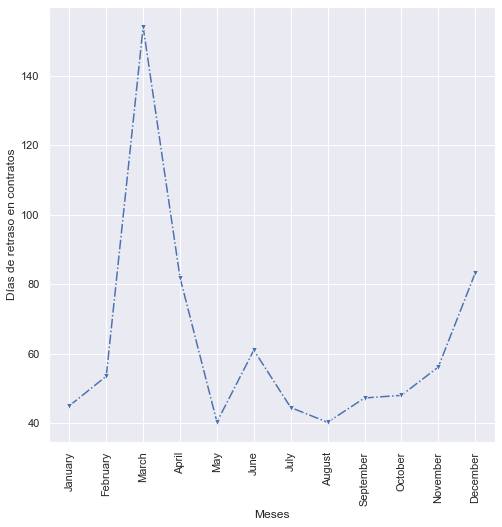

In [62]:
sns.set_theme(style="darkgrid")
fig,ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=dfg, x = "month", y = "contract_period",ax = ax, marker = "v", color = "b",linestyle="-.")
_=plt.xticks(rotation=90)
ax.set_xlabel("Meses")
ax.set_ylabel("Días de retraso en contratos")

#### ¿Que licitadores presentan mayor retraso en la firma de licitaciones?

In [63]:
df_NF061 = df_NF061.merge(tender[['ocid', 'procuringEntity_name']], on='ocid')

In [64]:
dfg2 = df_NF061.groupby('procuringEntity_name')['contract_period'].mean().reset_index()

In [65]:
dfg2.sort_values(by='contract_period', ascending = False, inplace = True)

In [66]:
dfg2

,procuringEntity_name,contract_period
5,Comando Provincial de Policìa Manabì No. 4,378.000000
1,BASE NAVAL DE SALINAS,189.000000
14,FEDERACION DE CENTROS AWA DEL ECUADOR FCAE,154.000000
29,MUNICIPIO DE MORONA,133.000000
0,ACERIAS NACIONALES DEL ECUADOR SOCIEDAD ANONIM...,126.000000
20,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE...,108.000000
26,JUNTA PARROQUIAL EL VALLE,105.000000
3,CORPORACION ELECTRICA DEL ECUADOR CELEC EP.,98.333333
10,EMPRESA ELÉCTRICA QUITO S.A. E.E.Q.,93.666667
21,GOBIERNO AUTÓNOMO DESCENTRALIZADO MUNICIPAL DE...,92.000000


Text(0.5, 0, 'Promedio de días de retraso')

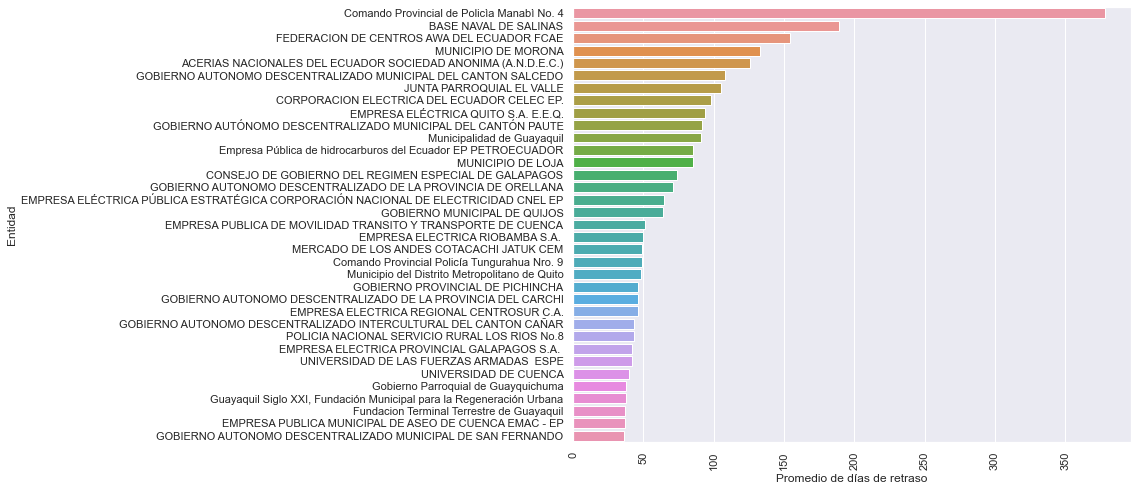

In [67]:
sns.set_theme(style="darkgrid")
fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(data=dfg2, y = "procuringEntity_name", x = "contract_period",ax = ax)
_=plt.xticks(rotation=90)
ax.set_ylabel("Entidad")
ax.set_xlabel("Promedio de días de retraso")